In [1]:
# pangenome of single organism with different threshold
organisms = ['Escherichia', 'Enterobacter', 'Klebsiella', 'Citrobacter', 'Salmonella','Acinetobacter', 'Pseudomonas']
threshold = ['0.70', '0.80', '0.90', '0.95', '0.97']



In [13]:
import pandas as pd
def parse_card_detail(p): # derived from card_complete_parse.py
    with open(p) as f:
        all_lines = f.readlines()


    card_detail = pd.DataFrame(columns = ['ARO', 'ARO_name', 'ARO_group', 'snp', 'cut_off', 'best_ARO', 'best_identity'])

    # parsing                                                                                                                         
    header = all_lines[0].split('\t') # len = 25                                                                                      
    for i in range(1, len(all_lines)):
        attr = all_lines[i].split('\t')

        gene_header = attr[0].split(' ')[0] # JMUY01000005_592|1438670.3                                                              
        cut_off = attr[5] # strict                                                                                                    
        ARO = attr[10] # can be more than one                                                                                         
        best_ARO = attr[8]
        best_identity = attr[9]
        ARO_name = attr[11] # string                                                                                                  
        snp = attr[13] # can be 'n/a'                                                                                                 
        ARO_group = attr[15]

        card_detail.loc[gene_header] = pd.Series({'ARO':ARO, 'ARO_name':ARO_name, 'ARO_group':ARO_group, 'snp':snp, 'cut_off': cut_of\
f, 'best_ARO': best_ARO, 'best_identity' : best_identity})
    return(card_detail)


In [14]:
p = '/home/hermuba/data0118/predicted_genes/card/'
import os
onlyfiles = [f for f in os.listdir(p)]
for f in onlyfiles:
    card = parse_card_detail(p+f)
    card.to_pickle(p+f[:-4])

In [3]:
def redundant_cluster(filename):
    card_detail = parse_card_detail("/home/hermuba/data0118/cdhit/card/"+filename +'.txt')
    aro_pattern = pd.DataFrame()
    for i in card_detail.index: # for each cluster
        aro_list = card_detail.loc[i, 'ARO'].split(',')
        for aro in aro_list:
            aro_pattern.loc[i, aro] = 1
    aro_pattern.fillna(0, inplace = True)
    aro_pattern.to_pickle("/home/hermuba/data0118/cdhit/card/"+filename+'_df')
    
    # calculate which cluster is redundant
    import itertools
    comb = [list(x) for x in itertools.combinations(aro_pattern.index, 2)]
    repeats = 0
    for c in comb:
        if aro_pattern.loc[c[0]].dot(aro_pattern.loc[c[1]])>0:
            #print(card_detail.loc[c]['ARO_name']) # to print out what the repeats are
            repeats += 1
    return(aro_pattern, repeats)
            

In [111]:
redun_df = pd.DataFrame(columns = organisms, index = threshold)
for sps in organisms:
    for t in threshold:
        aro, redun_df.loc[t, sps] = redundant_cluster(sps+t)


In [112]:
redun_df

,Escherichia,Enterobacter,Klebsiella,Citrobacter,Salmonella,Acinetobacter,Pseudomonas
0.70,5,4,7,2,0,3,7
0.80,9,10,13,3,0,4,28
0.90,37,17,47,4,1,10,108
0.95,111,90,138,11,4,105,201
0.97,165,249,219,21,8,340,271


In [4]:
def card_txt_parser(filename): # from card_parser.py
    card_detail = parse_card_detail("/home/hermuba/data0118/cdhit/card/"+filename +'.txt')
    list_aro = card_detail['best_ARO']
    return(list_aro)

def compare_thres_card(sps):
    df = pd.DataFrame()
    for t in threshold:
        list_aro = card_txt_parser(sps+t)
        for i in list_aro:
            df.loc[t, i] =1
    df.fillna(0, inplace = True)
    return(df)

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.style.use("ggplot")
# plot inline
%matplotlib inline

def plot_heatmap(df, **kwargs):
    """
    input: df is the output of compare_thres_card
    output: a figure to plot the difference
    
    kwargs:
    sort_col_name = True, default = False
    figsize = (width, height), default = (10,1)
    cmap = any colormap, default: GnBu
    """
    
    # sort the df according to df column name alphabetically
    if 'sort_col_name' in kwargs.keys():
        if kwargs['sort_col_name'] == True:
            m = df[sorted(df.columns)]
    else: 
        m = df
    
    if 'cmap' in kwargs.keys():
        color = kwargs['cmap']
    else:
        color = 'GnBu'
    
    size = (len(m.columns)/6,1)
    
    plt.figure(figsize = size)

    plt.pcolor(m, cmap=color, vmin=0, vmax=1)
    plt.xticks(np.arange(0.5, len(m.columns), 1), m.columns, rotation = 90)
    plt.yticks(np.arange(0.5, len(m.index), 1), m.index)

    plt.show()
    
    

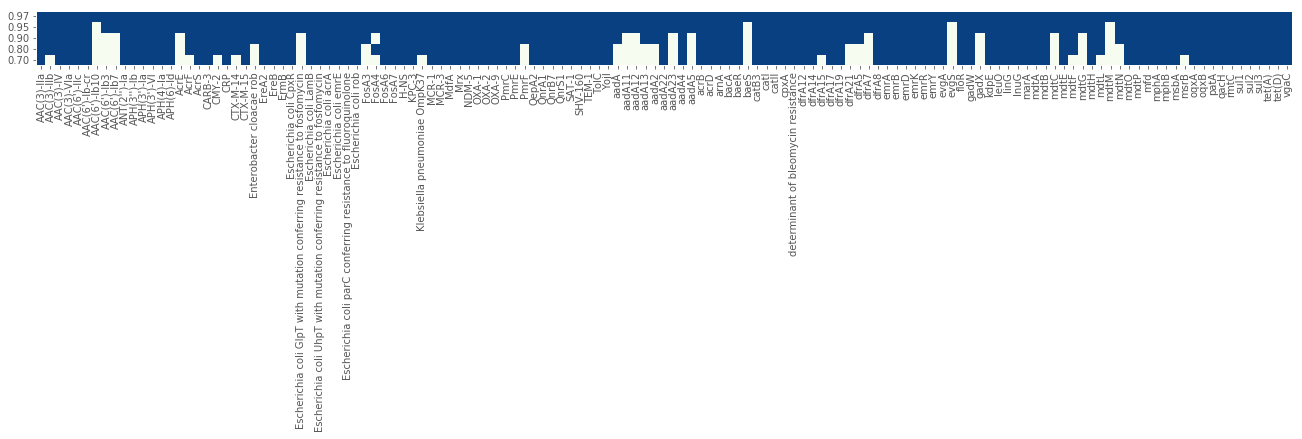

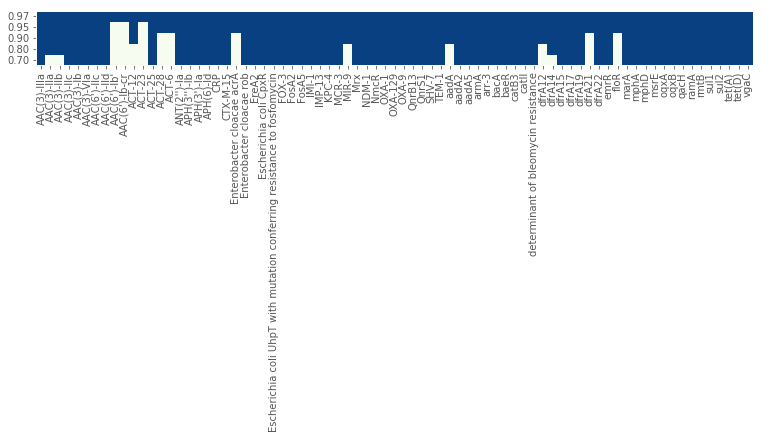

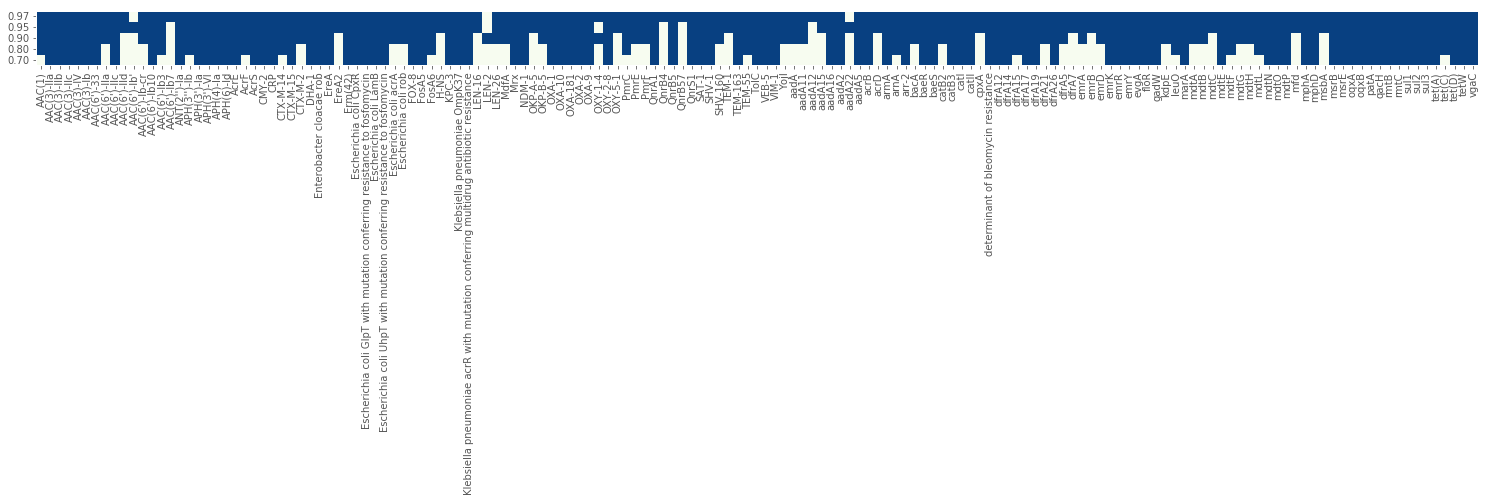

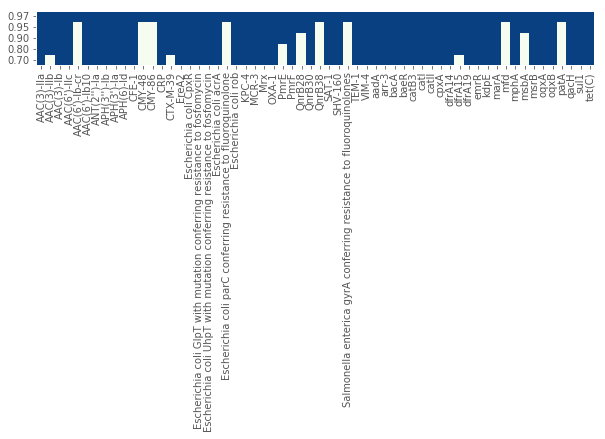

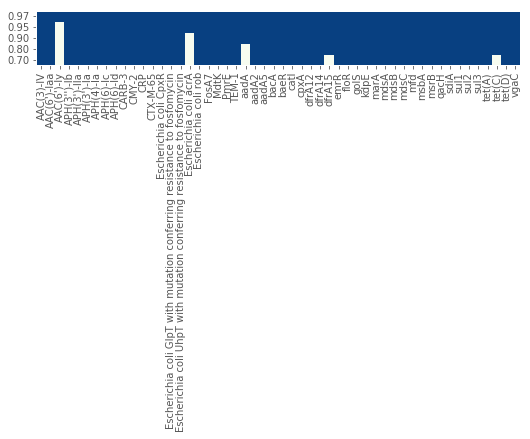

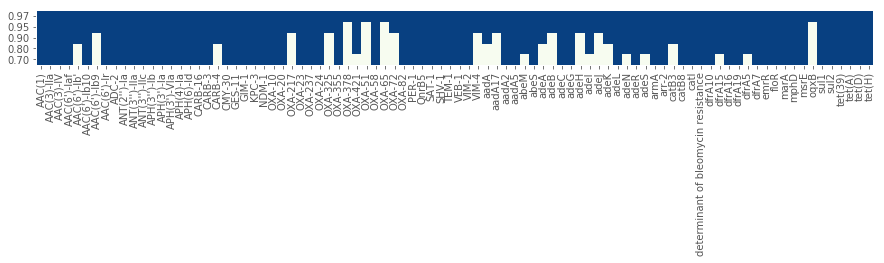

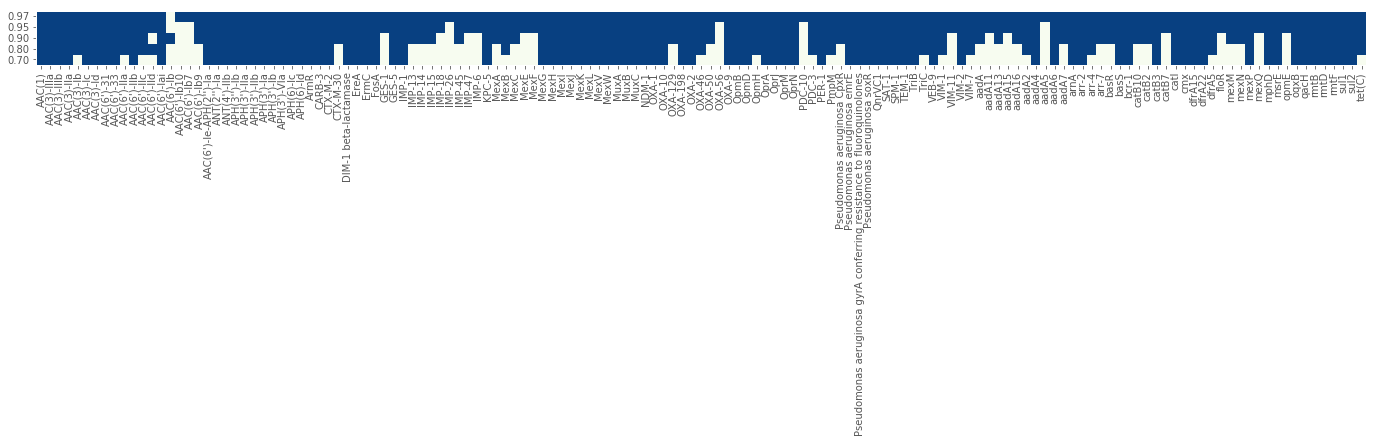

In [5]:
for sps in organisms:
    df = compare_thres_card(sps)
    plot_heatmap(df, sort_col_name = True)

In [3]:
# compare pfam
import pandas as pd
pfam_path = '/home/hermuba/data0118/cdhit/pfam/df/'
def redundant_pfam(filename):
    df = pd.read_pickle(pfam_path + filename)
    return(df.shape[0], len(df['hmm acc'].unique()), len(df.loc[df['type'] == 'Domain']['hmm acc']), len(df.loc[df['type'] == 'Domain']['hmm acc'].unique()), len(df.loc[df['type'] == 'Family']['hmm acc']), len(df.loc[df['type'] == 'Family']['hmm acc'].unique()))


In [6]:
organisms = ['Escherichia', 'Enterobacter', 'Klebsiella', 'Citrobacter', 'Salmonella','Acinetobacter', 'Pseudomonas']
thres = ['0.70', '0.80', '0.95']
pfam = pd.DataFrame(columns = ['total', 'unique', 'total_domain', 'unique_domain', 'total_family', 'unique_family'])
for o in organisms:
    for t in thres:
        
        pfam.loc[o+t] = redundant_pfam(o+t)

In [10]:
pfam

,total,unique,total_domain,unique_domain,total_family,unique_family
Escherichia0.70,24386,4074,11005,1734,11991,2277
Escherichia0.80,29922,4079,13101,1736,14452,2279
Escherichia0.95,52833,4093,22493,1740,25516,2286
Enterobacter0.70,16428,3679,8191,1619,7813,2006
Enterobacter0.80,19056,3689,9452,1625,9095,2010
Enterobacter0.95,35719,3701,17947,1628,16826,2018
Klebsiella0.70,23812,3960,11948,1722,11443,2182
Klebsiella0.80,28394,3970,14174,1725,13730,2188
Klebsiella0.95,51092,3977,25784,1729,24532,2190
Citrobacter0.70,10135,3289,5158,1472,4704,1769


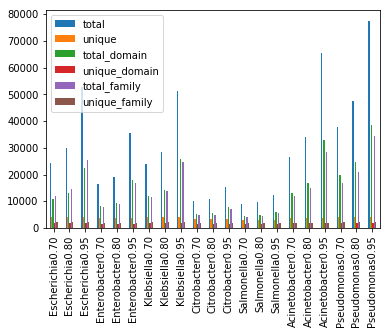

In [9]:
pfam.plot(kind = 'bar')

In [ ]:
# intra-cluster pfam: 16 core, nohup
# search 0.70
# mysql root root;